In [1]:
import json
import emip_toolkit as EMTK
from correction import find_lines_Y, draw_fixation, between_line_regression, error_noise
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload

In [2]:
file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)

In [3]:
# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")

# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()

# find the y coordinate of each line in the text
line_ys = find_lines_Y(aoi)

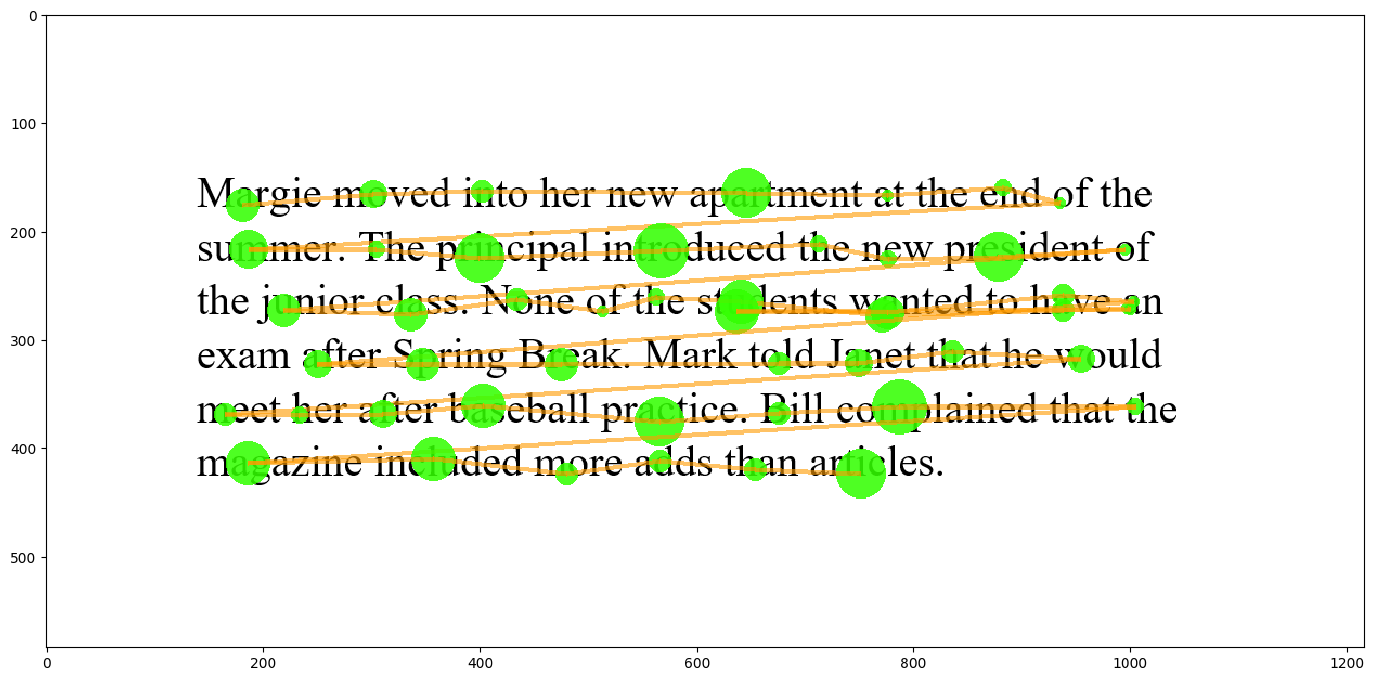

In [4]:
# draw original correct fixations

draw_fixation('synthetic_text.png', data['robot1'].copy())

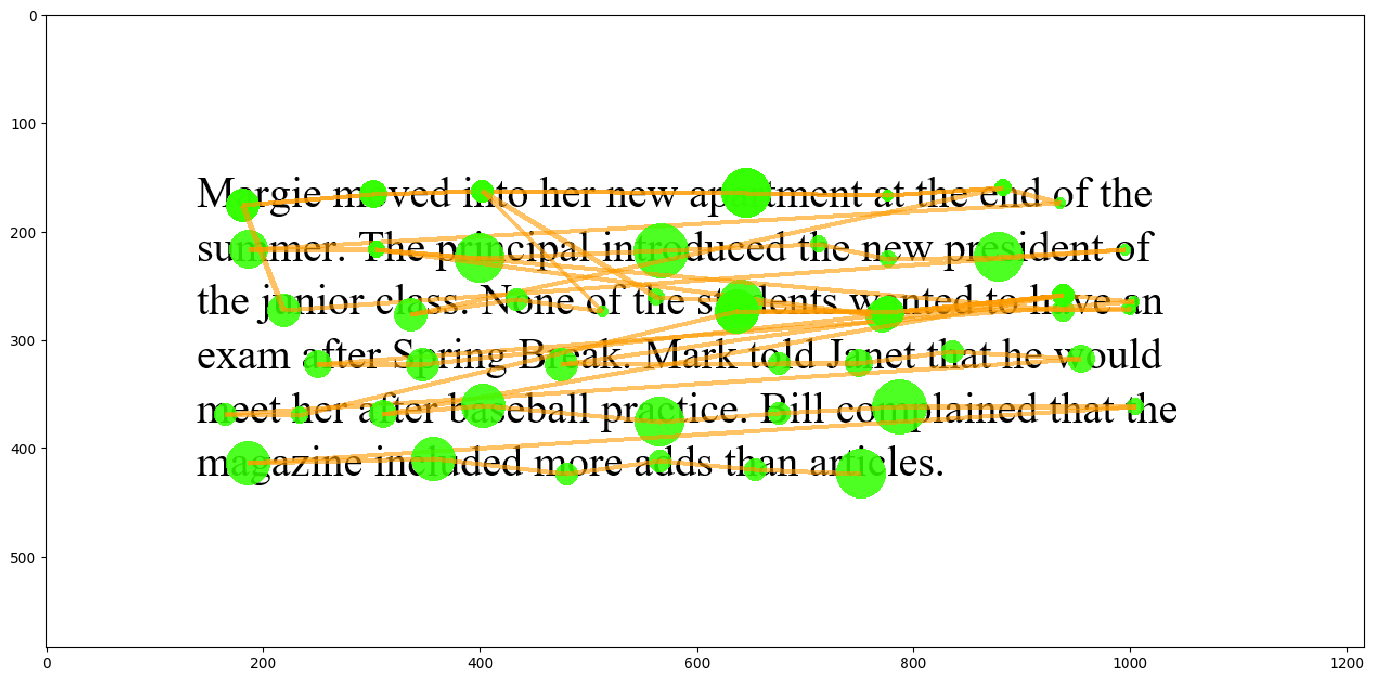

In [6]:
# add regressions
regression_test = between_line_regression(data['robot1'].copy(), 0.1)

# draw the trial with added error
draw_fixation('synthetic_text.png', regression_test)